# Project 59: Shape Classification

## Authors: Julen Etxaniz and Ibon Urbina

## Subject: Machine Learning and Neural Networks

## Date: 25/10/2020

## Objective: The goal of the project is to compare different classification algorithms on the solution of plane and car shape datasets. 

## Contents: 
### [1.Importing the libraries](#1.-Importing-the-libraries)
### [2.Reading the datasets](#2.-Reading-the-datasets)
### [3.Preprocessing the datasets](#3.-Preprocessing-the-datasets)
### [4.Dividing train and test data](#4.-Dividing-train-and-test-data)
### [5.Scaling the data](#5.-Scaling-the-data)
### [6.Classification](#6.-Classification)
### [7.Validation](#7.-Validation)
### [8.Feature Selection](#8.-Feature-Selection)
### [9.Feature Engineering](#9.-Feature-Engineering)
### [10.Pipeline Optimization](#10.-Pipeline-Optimization)

# 1. Importing the libraries
 We start by importing all relevant libraries to be used in the notebook.
    

In [2]:
# Reading data
from os import listdir
from scipy.io import loadmat
from re import findall

# Preprocessing
import pandas as pd
import numpy as np

# Scaling
from sklearn.preprocessing import StandardScaler

# Classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

# Validation
from sklearn.metrics import accuracy_score

# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# Feature Extraction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Pipeline Optimization
from tpot import TPOTClassifier

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Enables interaction with the plots
%matplotlib notebook

# Images
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

# 2. Reading the datasets
We read the plane and car datasets

We use this function to read all the mats of the given directory.

In [3]:
def read_mats(dir):
    mats = []
    mats_file_name = []

    files = listdir(dir)
    # Files ordered before appending to maintain same order
    sorted_files = sorted(files)
    for file in sorted_files:
        mats.append(loadmat(dir + file))
        # To know in which order are we reading the files
        mats_file_name.append(file)
    
    return mats, mats_file_name

## 2.1. Reading the plane dataset
We read the 210 files that contain the instances of the plane classification problem.

We concatenate all the instances in a unique dataframe called "plane_mats".

In [4]:
plane_dir = "shape_data/plane_data/"
plane_mats, plane_mats_file_name = read_mats(plane_dir)

We check the dataset is correct, looking at the number of samples

In [5]:
print('The number of samples in the plane dataset is', len(plane_mats))

The number of samples in the plane dataset is 210


## 2.2. Reading the car dataset
We read the 120 files that contain the instances of the car classification problem.

We concatenate all the instances in a unique dataframe called "car_mats"

In [6]:
car_dir = "shape_data/car_data/"
car_mats, car_mats_file_name = read_mats(car_dir)

We check the dataset is correct, looking at the number of samples

In [7]:
print('The number of samples in the car dataset is', len(car_mats))

The number of samples in the car dataset is 120


# 3. Preprocessing the datasets

### Create dataframe
One of the best ways to represent data are pandas DataFrames. Either for their flexibility and eassy management of information. That's what we are going to do in the next cell: convert the list where we read all the data to a DataFrame.

In [8]:
def get_dataframe(mats):
    df = pd.DataFrame(mats)
    # Remove unnecessary columns
    df = df.drop(['__header__', '__version__', '__globals__'], axis=1)
    return df

### Get class and sample numbers

In [9]:
# Remember we have the names of the files read (in order) in our list called 
# Lets divide that array in two arrays. One containing the class number and the other the sample number.
def get_samples_classes(mats_file_name):
    class_n = []
    sample_n = []

    for i in mats_file_name:
        class_n.append(int(findall(r'\d+', str(i))[0]))
        sample_n.append(int(findall(r'\d+', str(i))[1]))
    
    return class_n, sample_n

In [10]:
# Add sample and class numbers to dataframe
def add_samples_classes(df, class_n, sample_n):
    df['Class'] = class_n
    df['Sample'] = sample_n

### Check if classes are balanced

In [11]:
# Print the number of samples in each class
def print_class_count(df):
    print("Quantity of samples in each class:")
    print(df['Class'].value_counts())

### Add another feature

In [12]:
# Calculate the perimeter (number of points) and add it to dataframe
def add_perimeter(df):
    length_list = []
    for i in range(len(df)):
        length_list.append(len(df['x'][i]))

    df['Perimeter_length'] = length_list
    
    return df

### Changing how x feature is represented

When learning a classifier is useful to have features as arrays of numbers, and not as arrays of sequences. In our case, x is an array of (x, y) coordinates; so we are going to separate x and y, an then create two extra features from there.

In [13]:
# Calculate the minimum perimeter length
def min_length(df):
    return min(df['Perimeter_length'][i] for i in range(len(df['Perimeter_length'])))

In [14]:
# Separate x and y coordinates and normalize number of coordinates to min_length
def separate_coordinates(df, min_length):
    x_coordinates = []
    y_coordinates = []

    for i in range(len(df['x'])):
        x_coordinates.append(np.resize((df['x'][i])[:,0], (min_length, 1)))
        y_coordinates.append(np.resize((df['x'][i])[:,1], (min_length, 1)))
    
    return x_coordinates, y_coordinates

In [15]:
# Get column stacks from x and y coordinate arrays
def get_stacks(x_coordinates, y_coordinates):
    x_stack = x_coordinates[0]
    y_stack = y_coordinates[0]
    
    for i in range(len(x_coordinates)-1):
        x_stack = np.column_stack((x_stack, x_coordinates[i+1]))
        y_stack = np.column_stack((y_stack, y_coordinates[i+1]))
    
    return x_stack, y_stack

In [16]:
# Insert those columns in the dataFrame with the point name
def insert_columns(df, x_stack, y_stack):
    for i in range(len(x_stack)):
        stringX = "x" + str(i)
        stringY = "y" + str(i)
        df[stringX] = x_stack[i]
        df[stringY] = y_stack[i]
        
    return df

### Preparing data for classification
To learn the classifiers, we need to separate in two different sets the features and the classes. 

In [17]:
# The selected features are: 'Perimeter_length', 'xJ' and 'yJ'
# Then we are going to put all Classes in a unique structure.
def get_features_target(df):
    features = df.drop(columns=['x', 'Class', 'Sample'])
    target = df['Class']
    
    return features, target

## 3.1. Preprocessing the plane dataset

In this problem there are four classes that correspond to the 7 types of planes: (a) Mirage, (b) Eurofighter, (c) F-14 wings closed, (d) F-14 wings opened, (e) Harrier, (f) F-22, (g) F-15. However, in the database files are written like this: "ClassX_SampleY.mat", where X is the corresponding class number and Y the corresponding sample number. 

Here is the correspondance of class number and class name (plane model name):
* 1 = Mirage
* 2 = Eurofighter
* 3 = F-14 wings closed
* 4 = F-14 wings opened
* 5 = Harrier
* 6 = F-22
* 7 = F-15

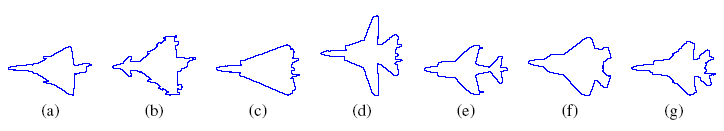

In [18]:
Image(filename='shape_plane.png')

### Create dataframe

In [19]:
plane_df = get_dataframe(plane_mats)
plane_df

,x
0,"[[64, 235], [65, 234], [66, 234], [67, 234], [..."
1,"[[60, 139], [61, 138], [62, 137], [63, 137], [..."
2,"[[60, 219], [61, 218], [62, 217], [63, 217], [..."
3,"[[54, 201], [55, 200], [55, 199], [56, 198], [..."
4,"[[64, 275], [65, 274], [66, 274], [67, 274], [..."
...,...
205,"[[33, 234], [34, 233], [35, 232], [36, 231], [..."
206,"[[21, 155], [22, 154], [23, 153], [24, 152], [..."
207,"[[45, 324], [46, 323], [47, 322], [48, 321], [..."
208,"[[70, 255], [71, 254], [72, 254], [73, 253], [..."


### Get class and sample numbers

In [20]:
plane_class_n, plane_sample_n = get_samples_classes(plane_mats_file_name)

In [21]:
print("This is how our class_n looks like: \n")
np.array(plane_class_n)

This is how our class_n looks like: 



array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

In [22]:
print("This is how our sample_n looks like: \n")
np.array(plane_sample_n)

This is how our sample_n looks like: 



array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30,  4,  5,  6,  7,  8,  9,  1, 10, 11, 12,
       13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29,  3, 30,  4,  5,  6,  7,  8,  9,  1, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19,  2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,  3, 30,  4,
        5,  6,  7,  8,  9,  1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29,  3, 30,  4,  5,  6,  7,  8,
        9,  1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29,  3, 30,  4,  5,  6,  7,  8,  9,  1, 10, 11,
       12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24, 25, 26, 27,
       28, 29,  3, 30,  4,  5,  6,  7,  8,  9,  1, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19,  2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,  3, 30,
        4,  5,  6,  7,  8,  9])

Lets add those lists to the car DataFrame.

In [23]:
add_samples_classes(plane_df, plane_class_n, plane_sample_n)
print("This is, finally, how our plane dataFrame looks like: \n")
plane_df

This is, finally, how our plane dataFrame looks like: 



,x,Class,Sample
0,"[[64, 235], [65, 234], [66, 234], [67, 234], [...",1,1
1,"[[60, 139], [61, 138], [62, 137], [63, 137], [...",1,10
2,"[[60, 219], [61, 218], [62, 217], [63, 217], [...",1,11
3,"[[54, 201], [55, 200], [55, 199], [56, 198], [...",1,12
4,"[[64, 275], [65, 274], [66, 274], [67, 274], [...",1,13
...,...,...,...
205,"[[33, 234], [34, 233], [35, 232], [36, 231], [...",7,5
206,"[[21, 155], [22, 154], [23, 153], [24, 152], [...",7,6
207,"[[45, 324], [46, 323], [47, 322], [48, 321], [...",7,7
208,"[[70, 255], [71, 254], [72, 254], [73, 253], [...",7,8


### Classes are balanced? Yes

Although in the description of the database it is said that each class has 30 samples, to make sure about it we are going to count them.

In [24]:
print_class_count(plane_df)

Quantity of samples in each class:
7    30
6    30
5    30
4    30
3    30
2    30
1    30
Name: Class, dtype: int64


### Add another feature

As we mentioned before, the only feature descriptor of the shapes is x, which refers to cartesian coordinates of each point on the perimeter of the shape. However, how many points are in each contour perimeter is not taken as a unique feature. It is implicitly measure in the length of each x sample, but, we prefer make it explicit.

In [25]:
plane_df = add_perimeter(plane_df)

In [26]:
print("This is how our plane dataFrame looks like: \n")
plane_df

This is how our plane dataFrame looks like: 



,x,Class,Sample,Perimeter_length
0,"[[64, 235], [65, 234], [66, 234], [67, 234], [...",1,1,1433
1,"[[60, 139], [61, 138], [62, 137], [63, 137], [...",1,10,1540
2,"[[60, 219], [61, 218], [62, 217], [63, 217], [...",1,11,1587
3,"[[54, 201], [55, 200], [55, 199], [56, 198], [...",1,12,1511
4,"[[64, 275], [65, 274], [66, 274], [67, 274], [...",1,13,1489
...,...,...,...,...
205,"[[33, 234], [34, 233], [35, 232], [36, 231], [...",7,5,1801
206,"[[21, 155], [22, 154], [23, 153], [24, 152], [...",7,6,1943
207,"[[45, 324], [46, 323], [47, 322], [48, 321], [...",7,7,1876
208,"[[70, 255], [71, 254], [72, 254], [73, 253], [...",7,8,1661


### Changing how x feature is represented

When learning a classifier is useful to have features as arrays of numbers, and not as arrays of sequences. In our case, x is an array of (x, y) coordinates; so we are going to separate x and y, an then create two extra features from there.

In [27]:
min_len = min_length(plane_df)
print(min_len)
x_coordinates, y_coordinates = separate_coordinates(plane_df, min_len)
x_stack, y_stack = get_stacks(x_coordinates, y_coordinates)
plane_df = insert_columns(plane_df, x_stack, y_stack)
plane_df

890


,x,Class,Sample,Perimeter_length,x0,y0,x1,y1,x2,y2,...,x885,y885,x886,y886,x887,y887,x888,y888,x889,y889
0,"[[64, 235], [65, 234], [66, 234], [67, 234], [...",1,1,1433,64,235,65,234,66,234,...,471,264,471,265,471,266,471,267,471,268
1,"[[60, 139], [61, 138], [62, 137], [63, 137], [...",1,10,1540,60,139,61,138,62,137,...,560,304,559,303,558,303,557,302,556,301
2,"[[60, 219], [61, 218], [62, 217], [63, 217], [...",1,11,1587,60,219,61,218,62,217,...,564,246,563,246,562,246,561,246,560,246
3,"[[54, 201], [55, 200], [55, 199], [56, 198], [...",1,12,1511,54,201,55,200,55,199,...,502,227,501,228,500,228,499,228,498,228
4,"[[64, 275], [65, 274], [66, 274], [67, 274], [...",1,13,1489,64,275,65,274,66,274,...,490,234,490,235,490,236,490,237,491,238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,"[[33, 234], [34, 233], [35, 232], [36, 231], [...",7,5,1801,33,234,34,233,35,232,...,533,202,533,203,534,204,534,205,534,206
206,"[[21, 155], [22, 154], [23, 153], [24, 152], [...",7,6,1943,21,155,22,154,23,153,...,586,260,585,259,584,258,583,259,582,259
207,"[[45, 324], [46, 323], [47, 322], [48, 321], [...",7,7,1876,45,324,46,323,47,322,...,597,157,597,158,597,159,597,160,596,161
208,"[[70, 255], [71, 254], [72, 254], [73, 253], [...",7,8,1661,70,255,71,254,72,254,...,531,296,530,297,529,298,528,299,528,300


### Preparing data for classification

In [28]:
plane_features, plane_target = get_features_target(plane_df)

In [29]:
# The selected features are: 'Perimeter_length', 'xJ' and 'yJ'  (J -> [0, 889])
plane_features

,Perimeter_length,x0,y0,x1,y1,x2,y2,x3,y3,x4,...,x885,y885,x886,y886,x887,y887,x888,y888,x889,y889
0,1433,64,235,65,234,66,234,67,234,68,...,471,264,471,265,471,266,471,267,471,268
1,1540,60,139,61,138,62,137,63,137,64,...,560,304,559,303,558,303,557,302,556,301
2,1587,60,219,61,218,62,217,63,217,64,...,564,246,563,246,562,246,561,246,560,246
3,1511,54,201,55,200,55,199,56,198,57,...,502,227,501,228,500,228,499,228,498,228
4,1489,64,275,65,274,66,274,67,274,68,...,490,234,490,235,490,236,490,237,491,238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,1801,33,234,34,233,35,232,36,231,37,...,533,202,533,203,534,204,534,205,534,206
206,1943,21,155,22,154,23,153,24,152,25,...,586,260,585,259,584,258,583,259,582,259
207,1876,45,324,46,323,47,322,48,321,49,...,597,157,597,158,597,159,597,160,596,161
208,1661,70,255,71,254,72,254,73,253,74,...,531,296,530,297,529,298,528,299,528,300


We have put all Classes in a unique structure.

In [30]:
plane_target

0      1
1      1
2      1
3      1
4      1
      ..
205    7
206    7
207    7
208    7
209    7
Name: Class, Length: 210, dtype: int64

## 3.2. Preprocessing the car dataset

In this problem there are four classes that correspond to the 4 types of cars: (a) sedan, (b) pickup, (c) minivan, or (d) SUV. However, in the database files are written like this: "ClassX_SampleY.mat", where X is the corresponding class number and Y the corresponding sample number. 

Here is the correspondance of class number and class name (car model name):
* 1 = sedan
* 2 = pickup
* 3 = minivan
* 4 = SUV

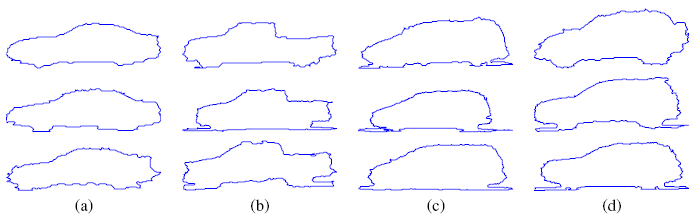

In [31]:
Image(filename='shape_car.png')

### Create dataframe

In [32]:
car_df = get_dataframe(car_mats)
car_df

,x
0,"[[113, 181], [114, 180], [114, 179], [114, 178..."
1,"[[98, 180], [99, 179], [99, 178], [100, 177], ..."
2,"[[70, 180], [71, 180], [72, 179], [73, 178], [..."
3,"[[54, 184], [55, 183], [56, 183], [57, 183], [..."
4,"[[44, 180], [45, 179], [46, 179], [47, 178], [..."
...,...
115,"[[101, 182], [102, 182], [103, 182], [104, 182..."
116,"[[46, 180], [47, 180], [48, 179], [48, 178], [..."
117,"[[31, 173], [32, 173], [33, 174], [34, 174], [..."
118,"[[20, 170], [21, 171], [22, 170], [23, 170], [..."


### Get class and sample numbers

Now, the only attribute available in our car DataFrame is x, which refers to cartesian coordinates of each point on the perimeter of the shape. We need more information to include there, such as class value and sample number.

In [33]:
# Remember we have the names of the files read (in order) in our list called car_mats_file_name.
# Lets, divide that array in two arrays. One containing the class number and the other the sample number.
car_class_n, car_sample_n = get_samples_classes(car_mats_file_name)

In [34]:
print("This is how our class_n looks like: \n")
np.array(car_class_n)

This is how our class_n looks like: 



array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [35]:
print("This is how our sample_n looks like: \n")
np.array(car_sample_n)

This is how our sample_n looks like: 



array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30,  4,  5,  6,  7,  8,  9,  1, 10, 11, 12,
       13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29,  3, 30,  4,  5,  6,  7,  8,  9,  1, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19,  2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,  3, 30,  4,
        5,  6,  7,  8,  9,  1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29,  3, 30,  4,  5,  6,  7,  8,
        9])

Lets add those lists to the car DataFrame.

In [36]:
add_samples_classes(car_df, car_class_n, car_sample_n)
print("This is, finally, how our car dataFrame looks like: \n")
car_df

This is, finally, how our car dataFrame looks like: 



,x,Class,Sample
0,"[[113, 181], [114, 180], [114, 179], [114, 178...",1,1
1,"[[98, 180], [99, 179], [99, 178], [100, 177], ...",1,10
2,"[[70, 180], [71, 180], [72, 179], [73, 178], [...",1,11
3,"[[54, 184], [55, 183], [56, 183], [57, 183], [...",1,12
4,"[[44, 180], [45, 179], [46, 179], [47, 178], [...",1,13
...,...,...,...
115,"[[101, 182], [102, 182], [103, 182], [104, 182...",4,5
116,"[[46, 180], [47, 180], [48, 179], [48, 178], [...",4,6
117,"[[31, 173], [32, 173], [33, 174], [34, 174], [...",4,7
118,"[[20, 170], [21, 171], [22, 170], [23, 170], [...",4,8


### Classes are balanced? Yes

Although in the description of the database it is said that each class has 30 samples, to make sure about it we are going to count them.

In [37]:
print_class_count(car_df)

Quantity of samples in each class:
4    30
3    30
2    30
1    30
Name: Class, dtype: int64


### Let's add another feature to our database

As we mentioned before, the only feature descriptor of the shapes is x, which refers to cartesian coordinates of each point on the perimeter of the shape. However, how many points are in each contour perimeter is not taken as a unique feature. It is implicitly measure in the length of each x sample, but, we prefer make it explicit.

In [38]:
car_df = add_perimeter(car_df)

In [39]:
print("This is how our car dataFrame looks like: \n")
car_df

This is how our car dataFrame looks like: 



,x,Class,Sample,Perimeter_length
0,"[[113, 181], [114, 180], [114, 179], [114, 178...",1,1,310
1,"[[98, 180], [99, 179], [99, 178], [100, 177], ...",1,10,331
2,"[[70, 180], [71, 180], [72, 179], [73, 178], [...",1,11,344
3,"[[54, 184], [55, 183], [56, 183], [57, 183], [...",1,12,334
4,"[[44, 180], [45, 179], [46, 179], [47, 178], [...",1,13,322
...,...,...,...,...
115,"[[101, 182], [102, 182], [103, 182], [104, 182...",4,5,373
116,"[[46, 180], [47, 180], [48, 179], [48, 178], [...",4,6,358
117,"[[31, 173], [32, 173], [33, 174], [34, 174], [...",4,7,374
118,"[[20, 170], [21, 171], [22, 170], [23, 170], [...",4,8,356


### Changing how x feature is represented

When learning a classifier is useful to have features as arrays of numbers, and not as arrays of sequences. In our case, x is an array of (x, y) coordinates; so we are going to separate x and y, an then create two extra features from there.

In [40]:
min_len = min_length(car_df)
print(min_len)
x_coordinates, y_coordinates = separate_coordinates(car_df, min_len)
x_stack, y_stack = get_stacks(x_coordinates, y_coordinates)
car_df = insert_columns(car_df, x_stack, y_stack)
car_df

272


,x,Class,Sample,Perimeter_length,x0,y0,x1,y1,x2,y2,...,x267,y267,x268,y268,x269,y269,x270,y270,x271,y271
0,"[[113, 181], [114, 180], [114, 179], [114, 178...",1,1,310,113,181,114,180,114,179,...,150,189,149,189,148,190,147,191,146,191
1,"[[98, 180], [99, 179], [99, 178], [100, 177], ...",1,10,331,98,180,99,179,99,178,...,140,188,139,188,138,189,139,190,138,190
2,"[[70, 180], [71, 180], [72, 179], [73, 178], [...",1,11,344,70,180,71,180,72,179,...,131,186,130,187,129,187,128,187,127,187
3,"[[54, 184], [55, 183], [56, 183], [57, 183], [...",1,12,334,54,184,55,183,56,183,...,108,186,107,187,106,187,105,187,104,188
4,"[[44, 180], [45, 179], [46, 179], [47, 178], [...",1,13,322,44,180,45,179,46,179,...,84,189,83,189,82,190,81,191,82,192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,"[[101, 182], [102, 182], [103, 182], [104, 182...",4,5,373,101,182,102,182,103,182,...,186,188,185,188,184,188,183,188,182,188
116,"[[46, 180], [47, 180], [48, 179], [48, 178], [...",4,6,358,46,180,47,180,48,179,...,131,186,130,186,129,186,128,186,127,186
117,"[[31, 173], [32, 173], [33, 174], [34, 174], [...",4,7,374,31,173,32,173,33,174,...,111,187,110,188,109,188,108,189,107,189
118,"[[20, 170], [21, 171], [22, 170], [23, 170], [...",4,8,356,20,170,21,171,22,170,...,76,189,75,189,74,189,73,189,72,189


### Preparing data for classification

In [41]:
car_features, car_target = get_features_target(car_df)

In [42]:
# The selected features are: 'Perimeter_length', 'xJ' and 'yJ'  (J -> [0, 271])
car_features

,Perimeter_length,x0,y0,x1,y1,x2,y2,x3,y3,x4,...,x267,y267,x268,y268,x269,y269,x270,y270,x271,y271
0,310,113,181,114,180,114,179,114,178,114,...,150,189,149,189,148,190,147,191,146,191
1,331,98,180,99,179,99,178,100,177,101,...,140,188,139,188,138,189,139,190,138,190
2,344,70,180,71,180,72,179,73,178,72,...,131,186,130,187,129,187,128,187,127,187
3,334,54,184,55,183,56,183,57,183,58,...,108,186,107,187,106,187,105,187,104,188
4,322,44,180,45,179,46,179,47,178,48,...,84,189,83,189,82,190,81,191,82,192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,373,101,182,102,182,103,182,104,182,105,...,186,188,185,188,184,188,183,188,182,188
116,358,46,180,47,180,48,179,48,178,48,...,131,186,130,186,129,186,128,186,127,186
117,374,31,173,32,173,33,174,34,174,35,...,111,187,110,188,109,188,108,189,107,189
118,356,20,170,21,171,22,170,23,170,24,...,76,189,75,189,74,189,73,189,72,189


We have put all Classes in a unique structure.

In [43]:
car_target

0      1
1      1
2      1
3      1
4      1
      ..
115    4
116    4
117    4
118    4
119    4
Name: Class, Length: 120, dtype: int64

# 4. Dividing train and test data

Also, to evaluate the accuracy of the classifiers in the dataset we will split the data in two sets. Train and Test data. 
Each set will have the same number of samples of each class (15).

### Divide train and test features

In [44]:
def train_test_features(features):
    train_features = features[0::2]
    test_features = features[1::2]

    return train_features, test_features

### Divide train and test target

In [45]:
def train_test_target(target):
    train_target = target[0::2]
    test_target = target[1::2]

    return train_target, test_target

## 4.1. Dividing the plane data

In [46]:
plane_train_features, plane_test_features = train_test_features(plane_features)
plane_train_target, plane_test_target = train_test_features(plane_target)

## 4.2. Dividing the car data

In [47]:
car_train_features, car_test_features = train_test_features(car_features)
car_train_target, car_test_target = train_test_features(car_target)

# 5. Scaling the data

## 5.1. Scaling the plane data

In [49]:
plane_scaler = StandardScaler()
plane_scaler = plane_scaler.fit(plane_train_features)
plane_train_features_scaled = plane_scaler.transform(plane_train_features)
plane_test_features_scaled = plane_scaler.transform(plane_test_features)
plane_train_features_scaled

array([[-0.73999423, -0.24373978, -0.30372496, ...,  0.0414752 ,
        -0.87300239,  0.0528201 ],
       [ 0.13049222, -0.35786543, -0.62363589, ..., -0.33028419,
         0.5277887 , -0.33576091],
       [-0.42345371, -0.24373978,  0.49605237, ..., -0.48960965,
        -0.55821787, -0.47706309],
       ...,
       [ 2.30670835, -1.09968214,  2.01562929, ..., -2.29529812,
         0.59074561, -2.29632872],
       [ 2.14278557, -1.4705905 , -1.90327961, ..., -0.10014743,
         0.87405167, -0.10614486],
       [ 0.54877792, -0.0725513 ,  0.0961637 , ...,  0.6079657 ,
         0.02413348,  0.61802884]])

## 5.2. Scaling the car data

In [50]:
car_scaler = StandardScaler()
car_scaler = car_scaler.fit(car_train_features)
car_train_features_scaled = car_scaler.transform(car_train_features)
car_test_features_scaled = car_scaler.transform(car_test_features)
car_train_features_scaled

array([[-1.03401769,  0.63862483,  0.65780993, ...,  0.88122895,
        -0.64015655,  0.87599671],
       [-0.75473846, -0.16471601,  0.58205447, ...,  0.67629199,
        -0.8871205 ,  0.67008171],
       [-0.93544855, -0.65045698,  0.58205447, ...,  0.88122895,
        -1.47203511,  0.92747546],
       ...,
       [-0.55760017,  0.73203656,  0.12752169, ...,  0.72752623,
        -0.14622865,  0.72156046],
       [-0.63974112, -0.61309229,  0.58205447, ...,  0.62505775,
        -0.8871205 ,  0.61860296],
       [-0.65616931, -1.09883327, -0.17550015, ...,  0.77876047,
        -1.60201613,  0.77303921]])

# 6. Classification

### Defining the classifiers
We define the three classifiers used.

In [53]:
def get_classifiers():
    dt  = DecisionTreeClassifier()
    lda = LinearDiscriminantAnalysis()
    lg  = LogisticRegression(max_iter=2000)
    return dt, lda, lg

### Learning the classifiers
We used the train data to learn the three classifiers

In [54]:
def fit_classifiers(dt, lda, lg, train_features, train_target):
    dt.fit(train_features, train_target)
    lda.fit(train_features, train_target)
    lg.fit(train_features, train_target)

### Using the classifier for predictions
We predict the class of the samples in the test data with the three classifiers.

In [55]:
def predict_classifiers(dt, lda, lg, test_features):
    dt_test_predictions = dt.predict(test_features)
    lda_test_predictions = lda.predict(test_features)
    lg_test_predictions = lg.predict(test_features)
    
    return dt_test_predictions, lda_test_predictions, lg_test_predictions

## 6.1. Classification for the plane data

## Not scaled data

### Defining the classifiers
We define the three classifiers used.

In [56]:
plane_dt, plane_lda, plane_lg = get_classifiers()

### Learning the classifiers
We used the train data to learn the three classifiers

In [57]:
fit_classifiers(plane_dt, plane_lda, plane_lg, plane_train_features, plane_train_target)

### Using the classifier for predictions
We predict the class of the samples in the test data with the three classifiers.

In [58]:
plane_dt_test_predictions, plane_lda_test_predictions, plane_lg_test_predictions = \
predict_classifiers(plane_dt, plane_lda, plane_lg, plane_test_features)

## Scaled data

### Learning the classifiers
We used the train data to learn the three classifiers

In [59]:
fit_classifiers(plane_dt, plane_lda, plane_lg, plane_train_features_scaled, plane_train_target)

### Using the classifier for predictions
We predict the class of the samples in the test data with the three classifiers.

In [60]:
plane_dt_test_predictions_scaled, plane_lda_test_predictions_scaled, plane_lg_test_predictions_scaled = \
predict_classifiers(plane_dt, plane_lda, plane_lg, plane_test_features_scaled)

## 6.2. Classification for the car data

## Not scaled data

### Defining the classifiers
We define the three classifiers used.

In [61]:
car_dt, car_lda, car_lg = get_classifiers()

### Learning the classifiers
We used the train data to learn the three classifiers

In [62]:
fit_classifiers(car_dt, car_lda, car_lg, car_train_features, car_train_target)

### Using the classifier for predictions
We predict the class of the samples in the test data with the three classifiers.

In [63]:
car_dt_test_predictions, car_lda_test_predictions, car_lg_test_predictions = \
predict_classifiers(car_dt, car_lda, car_lg, car_test_features)

## Scaled data

### Learning the classifiers
We used the train data to learn the three classifiers

In [64]:
fit_classifiers(car_dt, car_lda, car_lg, car_train_features_scaled, car_train_target)

### Using the classifier for predictions
We predict the class of the samples in the test data with the three classifiers.

In [65]:
car_dt_test_predictions_scaled, car_lda_test_predictions_scaled, car_lg_test_predictions_scaled = \
predict_classifiers(car_dt, car_lda, car_lg, car_test_features_scaled)

# 7. Validation

### Computing the accuracy

We compute the accuracy using the three classifiers and print it. 

In [66]:
def print_accuracies(test_target, dt_test_predictions, lda_test_predictions, lg_test_predictions):
    dt_acc =  accuracy_score(test_target, dt_test_predictions)
    lda_acc =  accuracy_score(test_target, lda_test_predictions)
    lg_acc =  accuracy_score(test_target, lg_test_predictions)
    print("Accuracy for the decision tree :", dt_acc)
    print("Accuracy for LDA :", lda_acc)
    print("Accuracy for logistic regression:", lg_acc)

### Computing the confusion matrices
We compute the confusion matrices for the three classifiers. We print the confusion matrices and also generate the latex code to insert it in our written report. 


In [67]:
def print_confusion_matrices(test_target, dt_test_predictions, lda_test_predictions, lg_test_predictions):
    print("Confusion matrix decision tree")
    cm_dt = pd.crosstab(test_target, dt_test_predictions)
    print(cm_dt)
    print()
    #print(cm_dt.to_latex())
    
    print("Confusion matrix LDA")
    cm_lda = pd.crosstab(test_target, lda_test_predictions)
    print(cm_lda)
    print()
    #print(cm_lda.to_latex())
    
    print("Confusion matrix Logistic regression")
    cm_lg = pd.crosstab(test_target, lg_test_predictions)
    print(cm_lg)
    print()
    #print(cm_lg.to_latex())

## 7.1. Validation for the plane data

## Not scaled data

## Computing the accuracy

We compute the accuracy using the three classifiers and print it. Mention that accuracy score is a good measure as classes in both datasets are balanced.

In [72]:
print_accuracies(plane_test_target, plane_dt_test_predictions, plane_lda_test_predictions, plane_lg_test_predictions)

Accuracy for the decision tree : 0.8285714285714286
Accuracy for LDA : 0.9523809523809523
Accuracy for logistic regression: 0.9428571428571428


## Computing the confusion matrices
We compute the confusion matrices for the three classifiers. We print the confusion matrices and also generate the latex code to insert it in our written report. 


In [73]:
print_confusion_matrices(plane_test_target, plane_dt_test_predictions, plane_lda_test_predictions, plane_lg_test_predictions)

Confusion matrix decision tree
col_0   1  2   3   4   5   6   7
Class                           
1      10  3   0   0   0   1   1
2       1  9   0   0   1   0   4
3       0  0  12   0   0   2   1
4       0  1   0  14   0   0   0
5       0  0   0   0  14   1   0
6       0  0   0   0   0  15   0
7       2  0   0   0   0   0  13

Confusion matrix LDA
col_0   1   2   3   4   5   6   7
Class                            
1      13   0   0   0   0   2   0
2       0  12   0   0   0   0   3
3       0   0  15   0   0   0   0
4       0   0   0  15   0   0   0
5       0   0   0   0  15   0   0
6       0   0   0   0   0  15   0
7       0   0   0   0   0   0  15

Confusion matrix Logistic regression
col_0   1   2   3   4   5   6   7
Class                            
1      13   0   1   0   0   1   0
2       1  11   0   0   0   0   3
3       0   0  15   0   0   0   0
4       0   0   0  15   0   0   0
5       0   0   0   0  15   0   0
6       0   0   0   0   0  15   0
7       0   0   0   0   0   0  15


## Scaled data

## Computing the accuracy

We compute the accuracy using the three classifiers and print it. 

In [111]:
print_accuracies(plane_test_target, plane_dt_test_predictions_scaled, plane_lda_test_predictions_scaled, plane_lg_test_predictions_scaled)

Accuracy for the decision tree : 0.8
Accuracy for LDA : 0.9523809523809523
Accuracy for logistic regression: 0.9238095238095239


## Computing the confusion matrices
We compute the confusion matrices for the three classifiers. We print the confusion matrices and also generate the latex code to insert it in our written report. 


In [112]:
print_confusion_matrices(plane_test_target, plane_dt_test_predictions_scaled, plane_lda_test_predictions_scaled, plane_lg_test_predictions_scaled)

Confusion matrix decision tree
col_0  1  2   3   4   5   6   7
Class                          
1      8  3   2   0   0   1   1
2      2  9   0   0   1   0   3
3      1  0  11   0   0   2   1
4      0  1   0  14   0   0   0
5      0  0   0   0  14   1   0
6      0  0   0   0   0  15   0
7      2  0   0   0   0   0  13

Confusion matrix LDA
col_0   1   2   3   4   5   6   7
Class                            
1      13   0   0   0   0   2   0
2       0  12   0   0   0   0   3
3       0   0  15   0   0   0   0
4       0   0   0  15   0   0   0
5       0   0   0   0  15   0   0
6       0   0   0   0   0  15   0
7       0   0   0   0   0   0  15

Confusion matrix Logistic regression
col_0   1   2   3   4   5   6   7
Class                            
1      13   0   2   0   0   0   0
2       1  11   0   0   0   0   3
3       0   0  14   0   0   1   0
4       0   0   0  15   0   0   0
5       0   0   0   0  15   0   0
6       0   0   0   0   0  15   0
7       0   0   0   1   0   0  14



## 7.2. Validation for the car data

## Not scaled data

## Computing the accuracy

We compute the accuracy using the three classifiers and print it. 

In [113]:
print_accuracies(car_test_target, car_dt_test_predictions, car_lda_test_predictions, car_lg_test_predictions)

Accuracy for the decision tree : 0.8
Accuracy for LDA : 0.9
Accuracy for logistic regression: 0.8666666666666667


## Computing the confusion matrices
We compute the confusion matrices for the three classifiers. We print the confusion matrices and also generate the latex code to insert it in our written report. 


In [114]:
print_confusion_matrices(car_test_target, car_dt_test_predictions, car_lda_test_predictions, car_lg_test_predictions)

Confusion matrix decision tree
col_0   1   2   3  4
Class               
1      14   0   0  1
2       0  10   0  5
3       0   0  15  0
4       0   4   2  9

Confusion matrix LDA
col_0   1   2   3   4
Class                
1      13   0   0   2
2       0  15   0   0
3       0   1  13   1
4       0   0   2  13

Confusion matrix Logistic regression
col_0   1   2   3   4
Class                
1      14   0   1   0
2       0  14   1   0
3       0   1  12   2
4       0   0   3  12



## Scaled data

## Computing the accuracy

We compute the accuracy using the three classifiers and print it. 

In [115]:
print_accuracies(car_test_target, car_dt_test_predictions_scaled, car_lda_test_predictions_scaled, car_lg_test_predictions_scaled)

Accuracy for the decision tree : 0.8166666666666667
Accuracy for LDA : 0.9
Accuracy for logistic regression: 0.9166666666666666


## Computing the confusion matrices
We compute the confusion matrices for the three classifiers. We print the confusion matrices and also generate the latex code to insert it in our written report. 


In [116]:
print_confusion_matrices(car_test_target, car_dt_test_predictions_scaled, car_lda_test_predictions_scaled, car_lg_test_predictions_scaled)

Confusion matrix decision tree
col_0   1   2   3  4
Class               
1      14   0   0  1
2       0  11   1  3
3       0   0  15  0
4       0   4   2  9

Confusion matrix LDA
col_0   1   2   3   4
Class                
1      13   0   0   2
2       0  15   0   0
3       0   1  13   1
4       0   0   2  13

Confusion matrix Logistic regression
col_0   1   2   3   4
Class                
1      14   0   0   1
2       0  15   0   0
3       0   1  14   0
4       0   0   3  12



# 8. Feature Selection

# 8.1 Feature Selection with SelectKBest

At this point we have so many features: two features for each point in the contour perimeter. We normalized the length of each car image to 890 points, so 890 * 2 = 1780 features for representing each image. We normalized the length of each car image to 272 points, so 272 * 2 = 544 features for representing each image. Let's try reducing this amount of features...

We are going to use SelectKBest + f_classif function for our feature selection process.

### Feature selection

In [158]:
def feature_selection(features, target):
    reduced_data_100 = SelectKBest(f_classif, k=100).fit_transform(features, target)

    reduced_data_200 = SelectKBest(f_classif, k=200).fit_transform(features, target)

    reduced_data_300 = SelectKBest(f_classif, k=300).fit_transform(features, target)

    reduced_data_400 = SelectKBest(f_classif, k=400).fit_transform(features, target)

    reduced_data_500 = SelectKBest(f_classif, k=500).fit_transform(features, target)
    
    return reduced_data_100, reduced_data_200, reduced_data_300, reduced_data_400, reduced_data_500

## Plane Dataset

### Feature selection

In [159]:
# Not Scaled data

plane_reduced_data_100, plane_reduced_data_200, plane_reduced_data_300, plane_reduced_data_400, plane_reduced_data_500 = \
feature_selection(plane_features, plane_target)

In [160]:
# Scaled data

plane_reduced_data_100_scaled, plane_reduced_data_200_scaled, plane_reduced_data_300_scaled, plane_reduced_data_400_scaled, \
plane_reduced_data_500_scaled = feature_selection(plane_features, plane_target)

### Divide train and test features

As always, we need to separate the data in three: features data for training, features data for testing and class target:

In [161]:
# Not Scaled data
plane_reduced_data_train_100, plane_reduced_data_test_100 = train_test_features(plane_reduced_data_100)

plane_reduced_data_train_200, plane_reduced_data_test_200 = train_test_features(plane_reduced_data_200)

plane_reduced_data_train_300, plane_reduced_data_test_300 = train_test_features(plane_reduced_data_300)

plane_reduced_data_train_400, plane_reduced_data_test_400 = train_test_features(plane_reduced_data_400)

plane_reduced_data_train_500, plane_reduced_data_test_500 = train_test_features(plane_reduced_data_500)

In [162]:
# Scaled data
plane_reduced_data_train_100_scaled, plane_reduced_data_test_100_scaled = train_test_features(plane_reduced_data_100_scaled)

plane_reduced_data_train_200_scaled, plane_reduced_data_test_200_scaled = train_test_features(plane_reduced_data_200_scaled)

plane_reduced_data_train_300_scaled, plane_reduced_data_test_300_scaled = train_test_features(plane_reduced_data_300_scaled)

plane_reduced_data_train_400_scaled, plane_reduced_data_test_400_scaled = train_test_features(plane_reduced_data_400_scaled)

plane_reduced_data_train_500_scaled, plane_reduced_data_test_500_scaled = train_test_features(plane_reduced_data_500_scaled)

### Define classifiers
It is better to create one classifier of each type not to mix them:

In [163]:
plane_dt_100, plane_lda_100, plane_lg_100 = get_classifiers()

plane_dt_200, plane_lda_200, plane_lg_200 = get_classifiers()

plane_dt_300, plane_lda_300, plane_lg_300 = get_classifiers()

plane_dt_400, plane_lda_400, plane_lg_400 = get_classifiers()

plane_dt_500, plane_lda_500, plane_lg_500 = get_classifiers()

### Fit Classifiers

In [164]:
# Not Scaled data
fit_classifiers(plane_dt_100, plane_lda_100, plane_lg_100, plane_reduced_data_train_100, plane_train_target)

fit_classifiers(plane_dt_200, plane_lda_200, plane_lg_200, plane_reduced_data_train_200, plane_train_target)

fit_classifiers(plane_dt_300, plane_lda_300, plane_lg_300, plane_reduced_data_train_300, plane_train_target)

fit_classifiers(plane_dt_400, plane_lda_400, plane_lg_400, plane_reduced_data_train_400, plane_train_target)

fit_classifiers(plane_dt_500, plane_lda_500, plane_lg_500, plane_reduced_data_train_500, plane_train_target)

### Predict classifiers

In [165]:
# Not Scaled data
plane_dt_test_predictions_100, plane_lda_test_predictions_100, plane_lg_test_predictions_100 = \
predict_classifiers(plane_dt_100, plane_lda_100, plane_lg_100, plane_reduced_data_test_100)

plane_dt_test_predictions_200, plane_lda_test_predictions_200, plane_lg_test_predictions_200 = \
predict_classifiers(plane_dt_200, plane_lda_200, plane_lg_200, plane_reduced_data_test_200)

plane_dt_test_predictions_300, plane_lda_test_predictions_300, plane_lg_test_predictions_300 = \
predict_classifiers(plane_dt_300, plane_lda_300, plane_lg_300, plane_reduced_data_test_300)

plane_dt_test_predictions_400, plane_lda_test_predictions_400, plane_lg_test_predictions_400 = \
predict_classifiers(plane_dt_400, plane_lda_400, plane_lg_400, plane_reduced_data_test_400)

plane_dt_test_predictions_500, plane_lda_test_predictions_500, plane_lg_test_predictions_500 = \
predict_classifiers(plane_dt_500, plane_lda_500, plane_lg_500, plane_reduced_data_test_500)

### Fitting classifiers scaled

In [166]:
# Scaled data
fit_classifiers(plane_dt_100, plane_lda_100, plane_lg_100, plane_reduced_data_train_100_scaled, plane_train_target)

fit_classifiers(plane_dt_200, plane_lda_200, plane_lg_200, plane_reduced_data_train_200_scaled, plane_train_target)

fit_classifiers(plane_dt_300, plane_lda_300, plane_lg_300, plane_reduced_data_train_300_scaled, plane_train_target)

fit_classifiers(plane_dt_400, plane_lda_400, plane_lg_400, plane_reduced_data_train_400_scaled, plane_train_target)

fit_classifiers(plane_dt_500, plane_lda_500, plane_lg_500, plane_reduced_data_train_500_scaled, plane_train_target)

### Predicting classifiers scaled

In [167]:
# Scaled data
plane_dt_test_predictions_100_scaled, plane_lda_test_predictions_100_scaled, plane_lg_test_predictions_100_scaled = \
predict_classifiers(plane_dt_100, plane_lda_100, plane_lg_100, plane_reduced_data_test_100_scaled)

plane_dt_test_predictions_200_scaled, plane_lda_test_predictions_200_scaled, plane_lg_test_predictions_200_scaled = \
predict_classifiers(plane_dt_200, plane_lda_200, plane_lg_200, plane_reduced_data_test_200_scaled)

plane_dt_test_predictions_300_scaled, plane_lda_test_predictions_300_scaled, plane_lg_test_predictions_300_scaled = \
predict_classifiers(plane_dt_300, plane_lda_300, plane_lg_300, plane_reduced_data_test_300_scaled)

plane_dt_test_predictions_400_scaled, plane_lda_test_predictions_400_scaled, plane_lg_test_predictions_400_scaled = \
predict_classifiers(plane_dt_400, plane_lda_400, plane_lg_400, plane_reduced_data_test_400_scaled)

plane_dt_test_predictions_500_scaled, plane_lda_test_predictions_500_scaled, plane_lg_test_predictions_500_scaled = \
predict_classifiers(plane_dt_500, plane_lda_500, plane_lg_500, plane_reduced_data_test_500_scaled)

### Calculating accuracy
Let's see if the evolution of the accuracy depending on the quantity of fetures selected:

In [168]:
print("100 features + Not scaled: \n")
print_accuracies(plane_test_target, plane_dt_test_predictions_100, plane_lda_test_predictions_100, plane_lg_test_predictions_100)

print("\n")

print("100 features + Scaled: \n")
print_accuracies(plane_test_target, plane_dt_test_predictions_100_scaled, plane_lda_test_predictions_100_scaled, plane_lg_test_predictions_100_scaled)


100 features + Not scaled: 

Accuracy for the decision tree : 0.5714285714285714
Accuracy for LDA : 0.2571428571428571
Accuracy for logistic regression: 0.6190476190476191


100 features + Scaled: 

Accuracy for the decision tree : 0.5904761904761905
Accuracy for LDA : 0.2571428571428571
Accuracy for logistic regression: 0.6190476190476191


In [169]:
print("200 features + Not scaled: \n")
print_accuracies(plane_test_target, plane_dt_test_predictions_200, plane_lda_test_predictions_200, plane_lg_test_predictions_200)

print("\n")

print("200 features + Scaled: \n")
print_accuracies(plane_test_target, plane_dt_test_predictions_200_scaled, plane_lda_test_predictions_200_scaled, plane_lg_test_predictions_200_scaled)

200 features + Not scaled: 

Accuracy for the decision tree : 0.6571428571428571
Accuracy for LDA : 0.49523809523809526
Accuracy for logistic regression: 0.6285714285714286


200 features + Scaled: 

Accuracy for the decision tree : 0.6476190476190476
Accuracy for LDA : 0.49523809523809526
Accuracy for logistic regression: 0.6285714285714286


In [170]:
print("300 features + Not Scaled: \n")
print_accuracies(plane_test_target, plane_dt_test_predictions_300, plane_lda_test_predictions_300, plane_lg_test_predictions_300)

print("\n")

print("300 features + Scaled: \n")
print_accuracies(plane_test_target, plane_dt_test_predictions_300_scaled, plane_lda_test_predictions_300_scaled, plane_lg_test_predictions_300_scaled)

300 features + Not Scaled: 

Accuracy for the decision tree : 0.7333333333333333
Accuracy for LDA : 0.7047619047619048
Accuracy for logistic regression: 0.7047619047619048


300 features + Scaled: 

Accuracy for the decision tree : 0.7333333333333333
Accuracy for LDA : 0.7047619047619048
Accuracy for logistic regression: 0.7047619047619048


In [171]:
print("400 features + Not scaled: \n")
print_accuracies(plane_test_target, plane_dt_test_predictions_400, plane_lda_test_predictions_400, plane_lg_test_predictions_400)

print("\n")

print("400 features + Scaled: \n")
print_accuracies(plane_test_target, plane_dt_test_predictions_400_scaled, plane_lda_test_predictions_400_scaled, plane_lg_test_predictions_400_scaled)

400 features + Not scaled: 

Accuracy for the decision tree : 0.7619047619047619
Accuracy for LDA : 0.7714285714285715
Accuracy for logistic regression: 0.819047619047619


400 features + Scaled: 

Accuracy for the decision tree : 0.7523809523809524
Accuracy for LDA : 0.7714285714285715
Accuracy for logistic regression: 0.819047619047619


In [172]:
print("500 features + Not scaled: \n")
print_accuracies(plane_test_target, plane_dt_test_predictions_500, plane_lda_test_predictions_500, plane_lg_test_predictions_500)

print("\n")

print("500 features+ Scaled: \n")
print_accuracies(plane_test_target, plane_dt_test_predictions_500_scaled, plane_lda_test_predictions_500_scaled, plane_lg_test_predictions_500_scaled)

500 features + Not scaled: 

Accuracy for the decision tree : 0.7333333333333333
Accuracy for LDA : 0.780952380952381
Accuracy for logistic regression: 0.8761904761904762


500 features+ Scaled: 

Accuracy for the decision tree : 0.7619047619047619
Accuracy for LDA : 0.780952380952381
Accuracy for logistic regression: 0.8761904761904762


## Car Dataset

### Feature selection

In [173]:
# Not Scaled data

car_reduced_data_100, car_reduced_data_200, car_reduced_data_300, car_reduced_data_400, car_reduced_data_500 = \
feature_selection(car_features, car_target)

In [174]:
# Scaled data

car_reduced_data_100_scaled, car_reduced_data_200_scaled, car_reduced_data_300_scaled, car_reduced_data_400_scaled, \
car_reduced_data_500_scaled = feature_selection(car_features, car_target)

### Divide train and test features

As always, we need to separate the data in three: features data for training, features data for testing and class target:

In [175]:
# Not Scaled data
car_reduced_data_train_100, car_reduced_data_test_100 = train_test_features(car_reduced_data_100)

car_reduced_data_train_200, car_reduced_data_test_200 = train_test_features(car_reduced_data_200)

car_reduced_data_train_300, car_reduced_data_test_300 = train_test_features(car_reduced_data_300)

car_reduced_data_train_400, car_reduced_data_test_400 = train_test_features(car_reduced_data_400)

car_reduced_data_train_500, car_reduced_data_test_500 = train_test_features(car_reduced_data_500)

In [176]:
# Scaled data
car_reduced_data_train_100_scaled, car_reduced_data_test_100_scaled = train_test_features(car_reduced_data_100_scaled)

car_reduced_data_train_200_scaled, car_reduced_data_test_200_scaled = train_test_features(car_reduced_data_200_scaled)

car_reduced_data_train_300_scaled, car_reduced_data_test_300_scaled = train_test_features(car_reduced_data_300_scaled)

car_reduced_data_train_400_scaled, car_reduced_data_test_400_scaled = train_test_features(car_reduced_data_400_scaled)

car_reduced_data_train_500_scaled, car_reduced_data_test_500_scaled = train_test_features(car_reduced_data_500_scaled)

### Define classifiers
It is better to create one classifier of each type not to mix them:

In [177]:
car_dt_100, car_lda_100, car_lg_100 = get_classifiers()

car_dt_200, car_lda_200, car_lg_200 = get_classifiers()

car_dt_300, car_lda_300, car_lg_300 = get_classifiers()

car_dt_400, car_lda_400, car_lg_400 = get_classifiers()

car_dt_500, car_lda_500, car_lg_500 = get_classifiers()

### Fit Classifiers

In [178]:
# Not Scaled data
fit_classifiers(car_dt_100, car_lda_100, car_lg_100, car_reduced_data_train_100, car_train_target)

fit_classifiers(car_dt_200, car_lda_200, car_lg_200, car_reduced_data_train_200, car_train_target)

fit_classifiers(car_dt_300, car_lda_300, car_lg_300, car_reduced_data_train_300, car_train_target)

fit_classifiers(car_dt_400, car_lda_400, car_lg_400, car_reduced_data_train_400, car_train_target)

fit_classifiers(car_dt_500, car_lda_500, car_lg_500, car_reduced_data_train_500, car_train_target)

### Predict classifiers

In [179]:
# Not Scaled data
car_dt_test_predictions_100, car_lda_test_predictions_100, car_lg_test_predictions_100 = \
predict_classifiers(car_dt_100, car_lda_100, car_lg_100, car_reduced_data_test_100)

car_dt_test_predictions_200, car_lda_test_predictions_200, car_lg_test_predictions_200 = \
predict_classifiers(car_dt_200, car_lda_200, car_lg_200, car_reduced_data_test_200)

car_dt_test_predictions_300, car_lda_test_predictions_300, car_lg_test_predictions_300 = \
predict_classifiers(car_dt_300, car_lda_300, car_lg_300, car_reduced_data_test_300)

car_dt_test_predictions_400, car_lda_test_predictions_400, car_lg_test_predictions_400 = \
predict_classifiers(car_dt_400, car_lda_400, car_lg_400, car_reduced_data_test_400)

car_dt_test_predictions_500, car_lda_test_predictions_500, car_lg_test_predictions_500 = \
predict_classifiers(car_dt_500, car_lda_500, car_lg_500, car_reduced_data_test_500)

### Fitting classifiers scaled

In [180]:
# Scaled data
fit_classifiers(car_dt_100, car_lda_100, car_lg_100, car_reduced_data_train_100_scaled, car_train_target)

fit_classifiers(car_dt_200, car_lda_200, car_lg_200, car_reduced_data_train_200_scaled, car_train_target)

fit_classifiers(car_dt_300, car_lda_300, car_lg_300, car_reduced_data_train_300_scaled, car_train_target)

fit_classifiers(car_dt_400, car_lda_400, car_lg_400, car_reduced_data_train_400_scaled, car_train_target)

fit_classifiers(car_dt_500, car_lda_500, car_lg_500, car_reduced_data_train_500_scaled, car_train_target)

### Predicting classifiers scaled

In [181]:
# Scaled data
car_dt_test_predictions_100_scaled, car_lda_test_predictions_100_scaled, car_lg_test_predictions_100_scaled = \
predict_classifiers(car_dt_100, car_lda_100, car_lg_100, car_reduced_data_test_100_scaled)

car_dt_test_predictions_200_scaled, car_lda_test_predictions_200_scaled, car_lg_test_predictions_200_scaled = \
predict_classifiers(car_dt_200, car_lda_200, car_lg_200, car_reduced_data_test_200_scaled)

car_dt_test_predictions_300_scaled, car_lda_test_predictions_300_scaled, car_lg_test_predictions_300_scaled = \
predict_classifiers(car_dt_300, car_lda_300, car_lg_300, car_reduced_data_test_300_scaled)

car_dt_test_predictions_400_scaled, car_lda_test_predictions_400_scaled, car_lg_test_predictions_400_scaled = \
predict_classifiers(car_dt_400, car_lda_400, car_lg_400, car_reduced_data_test_400_scaled)

car_dt_test_predictions_500_scaled, car_lda_test_predictions_500_scaled, car_lg_test_predictions_500_scaled = \
predict_classifiers(car_dt_500, car_lda_500, car_lg_500, car_reduced_data_test_500_scaled)

### Calculating accuracy
Let's see if the evolution of the accuracy depending on the quantity of fetures selected:

In [182]:
print("100 features + Not scaled: \n")
print_accuracies(car_test_target, car_dt_test_predictions_100, car_lda_test_predictions_100, car_lg_test_predictions_100)

print("\n")

print("100 features + Scaled: \n")
print_accuracies(car_test_target, car_dt_test_predictions_100_scaled, car_lda_test_predictions_100_scaled, car_lg_test_predictions_100_scaled)

100 features + Not scaled: 

Accuracy for the decision tree : 0.7333333333333333
Accuracy for LDA : 0.43333333333333335
Accuracy for logistic regression: 0.6


100 features + Scaled: 

Accuracy for the decision tree : 0.75
Accuracy for LDA : 0.43333333333333335
Accuracy for logistic regression: 0.6


In [183]:
print("200 features + Not scaled: \n")
print_accuracies(car_test_target, car_dt_test_predictions_200, car_lda_test_predictions_200, car_lg_test_predictions_200)

print("\n")

print("200 features + Scaled: \n")
print_accuracies(car_test_target, car_dt_test_predictions_200_scaled, car_lda_test_predictions_200_scaled, car_lg_test_predictions_200_scaled)

200 features + Not scaled: 

Accuracy for the decision tree : 0.75
Accuracy for LDA : 0.6666666666666666
Accuracy for logistic regression: 0.7166666666666667


200 features + Scaled: 

Accuracy for the decision tree : 0.8166666666666667
Accuracy for LDA : 0.6666666666666666
Accuracy for logistic regression: 0.7166666666666667


In [184]:
print("300 features + Not Scaled: \n")
print_accuracies(car_test_target, car_dt_test_predictions_300, car_lda_test_predictions_300, car_lg_test_predictions_300)

print("\n")

print("300 features + Scaled: \n")
print_accuracies(car_test_target, car_dt_test_predictions_300_scaled, car_lda_test_predictions_300_scaled, car_lg_test_predictions_300_scaled)

300 features + Not Scaled: 

Accuracy for the decision tree : 0.8166666666666667
Accuracy for LDA : 0.8333333333333334
Accuracy for logistic regression: 0.8833333333333333


300 features + Scaled: 

Accuracy for the decision tree : 0.7833333333333333
Accuracy for LDA : 0.8333333333333334
Accuracy for logistic regression: 0.8833333333333333


In [185]:
print("400 features + Not scaled: \n")
print_accuracies(car_test_target, car_dt_test_predictions_400, car_lda_test_predictions_400, car_lg_test_predictions_400)

print("\n")

print("400 features + Scaled: \n")
print_accuracies(car_test_target, car_dt_test_predictions_400_scaled, car_lda_test_predictions_400_scaled, car_lg_test_predictions_400_scaled)

400 features + Not scaled: 

Accuracy for the decision tree : 0.8666666666666667
Accuracy for LDA : 0.8666666666666667
Accuracy for logistic regression: 0.85


400 features + Scaled: 

Accuracy for the decision tree : 0.7333333333333333
Accuracy for LDA : 0.8666666666666667
Accuracy for logistic regression: 0.85


In [186]:
print("500 features + Not scaled: \n")
print_accuracies(car_test_target, car_dt_test_predictions_500, car_lda_test_predictions_500, car_lg_test_predictions_500)

print("\n")

print("500 features+ Scaled: \n")
print_accuracies(car_test_target, car_dt_test_predictions_500_scaled, car_lda_test_predictions_500_scaled, car_lg_test_predictions_500_scaled)

500 features + Not scaled: 

Accuracy for the decision tree : 0.8166666666666667
Accuracy for LDA : 0.8833333333333333
Accuracy for logistic regression: 0.8666666666666667


500 features+ Scaled: 

Accuracy for the decision tree : 0.8333333333333334
Accuracy for LDA : 0.8833333333333333
Accuracy for logistic regression: 0.8666666666666667


# 8.2. Feature Selection with RandomForest

Apart from SelectKBest algorithm, exists the ensemble of decision trees called RandomForest that can be used as a feature selector. Let's see how does this algoritm performs comparing to the algorithm above.

### Plane dataset

In [109]:
## We are going to make 10 trials, and then. take the mean of 1)trees quantity and 2) accuracy percentage
for j in (range(1, 11)):
    max = 0
    n_estim = 0
    result1 = 0
    result2 = 0
    result3 = 0
    classifier = " "
    selected_features_final = []
    
    ## We are going to measure best accuracies obtained from 1 tree to 60 trees. But, we have one constrain: 
    ## we can continue computing with a superior tree quantity if with the actual tree quantity we obtain a better 
    ## accuracy regarding to the previous tree quantity.
    for i in (range(1, 60)):
        sel = SelectFromModel(RandomForestClassifier(n_estimators = i))
        sel.fit(plane_train_features, plane_train_target)
        # Obtain the selected features by the RandomForestClassifier
        selectedFeaturesBoolean= sel.get_support()
    
        # Take the selected features from each train and test sets
        selectedFeaturesTrainNames = plane_train_features.columns[(selectedFeaturesBoolean)]
        selectedFeaturesTestNames = plane_test_features.columns[(selectedFeaturesBoolean)]
    
        selectedTrainData = plane_train_features[selectedFeaturesTrainNames]
        selectedTestData = plane_test_features[selectedFeaturesTestNames]
        np.array(selectedTestData).shape
        
        # Create the classifiers we are going to use
        dt  = DecisionTreeClassifier()
        lda = LinearDiscriminantAnalysis()
        lg  = LogisticRegression(max_iter=2000)
    
        # Fit the classifiers with the selected features in the train set
        dt.fit(selectedTrainData, plane_train_target)
        lda.fit(selectedTrainData, plane_train_target)
        lg.fit(selectedTrainData, plane_train_target)
    
        # Predict labels with the selected features in the test set
        dt_selected_prediction = dt.predict(selectedTestData)
        lda_selected_prediction = lda.predict(selectedTestData)
        lg_selected_prediction = lg.predict(selectedTestData)
    
        # If we don't obtain now a better accuracy_score comparing to 
        # the previous accuracy_score's -> stop the process
        if (accuracy_score(plane_test_target, dt_selected_prediction)  < result1 and
            accuracy_score(plane_test_target, lda_selected_prediction) < result2 and
            accuracy_score(plane_test_target, lg_selected_prediction)  < result3):
            break; 
        else:  
            result1 = accuracy_score(plane_test_target, dt_selected_prediction)
            result2 = accuracy_score(plane_test_target, lda_selected_prediction)
            result3 = accuracy_score(plane_test_target, lg_selected_prediction)
    
            if (result1>max or result2>max or result3>max):
                n_estim = i
                selected_features_final = plane_train_features.columns[(selectedFeaturesBoolean)]
                if result1>max:
                    max = result1
                    classifier = "DT"
                elif result2>max:
                    max = result2
                    classifier = "LDA"
                elif result3>max:
                    max = result3
                    classifier = "LG"         
    print("TRIAL: " + str(j) + "\n")
    print("CLASSIFIER: " + classifier + ", " + "TREE_QUANTITY: " + str(n_estim) + ", "
          + "MAX_ACCURACY:" + str(max) + "\n" + "FEATURE_QUANTITY: " + str(len(selected_features_final)) + "\n")
    print("SELECTED_FEATURES: " + str(plane_train_features.columns[(selectedFeaturesBoolean)]) + "\n")
    print("\n")
          
          
    #(classifier, n_estim, max, selected_features_final)
    

TRIAL: 1

CLASSIFIER: LDA, TREE_QUANTITY: 3, MAX_ACCURACY:0.9428571428571428
FEATURE_QUANTITY: 40

SELECTED_FEATURES: Index(['x39', 'x48', 'x95', 'x134', 'x202', 'x221', 'y273', 'x306', 'y308',
       'y314', 'y322', 'x323', 'x368', 'x372', 'y372', 'x398', 'x426', 'y426',
       'x474', 'x484', 'x548', 'x563', 'x594', 'x604', 'y605', 'x606', 'x611',
       'x672', 'y682', 'x684', 'x696', 'y703', 'x720', 'y768', 'x790', 'x794',
       'y795', 'y798', 'y819', 'y821', 'y853'],
      dtype='object')



TRIAL: 2

CLASSIFIER: LDA, TREE_QUANTITY: 7, MAX_ACCURACY:0.9714285714285714
FEATURE_QUANTITY: 78

SELECTED_FEATURES: Index(['x3', 'x15', 'x18', 'x38', 'x39', 'x40', 'x43', 'x49', 'x62', 'x79',
       ...
       'y816', 'y817', 'y820', 'y835', 'y841', 'x845', 'x855', 'x863', 'x880',
       'x887'],
      dtype='object', length=150)



TRIAL: 3

CLASSIFIER: LDA, TREE_QUANTITY: 4, MAX_ACCURACY:0.9523809523809523
FEATURE_QUANTITY: 47

SELECTED_FEATURES: Index(['y2', 'y27', 'x40', 'x43', 'x95', 

### Car dataset

In [110]:
## We are going to make 10 trials, and then. take the mean of 1)trees quantity and 2) accuracy percentage
for j in (range(1, 11)):
    max = 0
    n_estim = 0
    result1 = 0
    result2 = 0
    result3 = 0
    classifier = " "
    selected_features_final = []
    
    ## We are going to measure best accuracies obtained from 1 tree to 60 trees. But, we have one constrain: 
    ## we can continue computing with a superior tree quantity if with the actual tree quantity we obtain a better 
    ## accuracy regarding to the previous tree quantity.
    for i in (range(1, 60)):
        sel = SelectFromModel(RandomForestClassifier(n_estimators = i))
        sel.fit(car_train_features, car_train_target)
        # Obtain the selected features by the RandomForestClassifier
        selectedFeaturesBoolean= sel.get_support()
    
        # Take the selected features from each train and test sets
        selectedFeaturesTrainNames = car_train_features.columns[(selectedFeaturesBoolean)]
        selectedFeaturesTestNames = car_test_features.columns[(selectedFeaturesBoolean)]
    
        selectedTrainData = car_train_features[selectedFeaturesTrainNames]
        selectedTestData = car_test_features[selectedFeaturesTestNames]
        np.array(selectedTestData).shape
    
        # Create the classifiers we are going to use
        dt  = DecisionTreeClassifier()
        lda = LinearDiscriminantAnalysis()
        lg  = LogisticRegression(max_iter=2000)
    
        # Fit the classifiers with the selected features in the train set
        dt.fit(selectedTrainData, car_train_target)
        lda.fit(selectedTrainData, car_train_target)
        lg.fit(selectedTrainData, car_train_target)
    
        # Predict labels with the selected features in the test set
        dt_selected_prediction = dt.predict(selectedTestData)
        lda_selected_prediction = lda.predict(selectedTestData)
        lg_selected_prediction = lg.predict(selectedTestData)
        
        # If we don't obtain now a better accuracy_score comparing to 
        # the previous accuracy_score's -> stop the process
        if (accuracy_score(car_test_target, dt_selected_prediction)  < result1 and
            accuracy_score(car_test_target, lda_selected_prediction) < result2 and
            accuracy_score(car_test_target, lg_selected_prediction)  < result3):
            break; 
        else:  
            result1 = accuracy_score(car_test_target, dt_selected_prediction)
            result2 = accuracy_score(car_test_target, lda_selected_prediction)
            result3 = accuracy_score(car_test_target, lg_selected_prediction)
    
            if (result1>max or result2>max or result3>max):
                n_estim = i
                selected_features_final = car_train_features.columns[(selectedFeaturesBoolean)]
                if result1>max:
                    max = result1
                    classifier = "DT"
                elif result2>max:
                    max = result2
                    classifier = "LDA"
                elif result3>max:
                    max = result3
                    classifier = "LG"  
    
    print("TRIAL: " + str(j) + "\n")
    print("CLASSIFIER: " + classifier + ", " + "TREE_QUANTITY: " + str(n_estim) + ", "
          + "MAX_ACCURACY:" + str(max) + "\n" + "FEATURE_QUANTITY: " + str(len(selected_features_final)) + "\n")
    print("SELECTED_FEATURES: " + str(car_train_features.columns[(selectedFeaturesBoolean)]) + "\n")
    print("\n")
          
          
    #(classifier, n_estim, max, selected_features_final)
    

TRIAL: 1

CLASSIFIER: LDA, TREE_QUANTITY: 4, MAX_ACCURACY:0.85
FEATURE_QUANTITY: 30

SELECTED_FEATURES: Index(['x0', 'y19', 'x22', 'y25', 'y35', 'y40', 'y45', 'y47', 'y53', 'x54',
       'x66', 'y78', 'y89', 'y101', 'y137', 'y146', 'y151', 'y152', 'y158',
       'y159', 'y165', 'y166', 'y169', 'y173', 'y176', 'y181', 'y183', 'y184',
       'y186', 'y198', 'x209', 'y209', 'y224', 'y231', 'y243', 'x265', 'x268',
       'x270', 'y271'],
      dtype='object')



TRIAL: 2

CLASSIFIER: DT, TREE_QUANTITY: 1, MAX_ACCURACY:0.8166666666666667
FEATURE_QUANTITY: 9

SELECTED_FEATURES: Index(['x5', 'x13', 'y53', 'y93', 'y157', 'y165', 'y167', 'y174', 'y175',
       'y189', 'y193', 'y208', 'y211', 'x260', 'y262'],
      dtype='object')



TRIAL: 3

CLASSIFIER: LG, TREE_QUANTITY: 4, MAX_ACCURACY:0.9166666666666666
FEATURE_QUANTITY: 34

SELECTED_FEATURES: Index(['x3', 'y3', 'y4', 'y12', 'y14', 'x15', 'y15', 'y17', 'y18', 'x21',
       ...
       'y238', 'y244', 'x251', 'y258', 'x260', 'x263', 'x265', '

# 9. Feature engineering

# 9.1. Using PCA

## PCA for the plane data

### Define and Fit

In [125]:
plane_pca = PCA(n_components=3)
plane_pca.fit(plane_train_features)

PCA(n_components=3)

In [126]:
print('Explained variation per principal component: {}'.format(plane_pca.explained_variance_ratio_))

Explained variation per principal component: [0.53829005 0.16718511 0.0947978 ]


### Transform

In [127]:
plane_train_features_trans = plane_pca.transform(plane_train_features)
plane_test_features_trans = plane_pca.transform(plane_test_features)

In [128]:
print(plane_test_features.shape, plane_test_features_trans.shape)

(105, 1781) (105, 3)


### Plotting

<IPython.core.display.Javascript object>


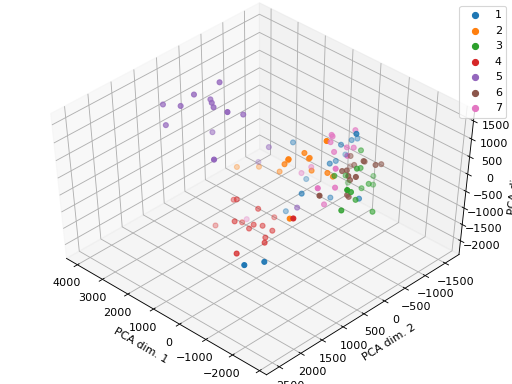

In [129]:
fig = plt.figure()
ax = Axes3D(fig, elev=48, azim=134)

for i in range(1, 8):
    ax.scatter(plane_test_features_trans[plane_test_target==i, 0], plane_test_features_trans[plane_test_target==i, 1], \
               plane_test_features_trans[plane_test_target==i, 2], label=str(i))

lgnd = plt.legend()
ax.set_xlabel('PCA dim. 1')
ax.set_ylabel('PCA dim. 2')
ax.set_zlabel('PCA dim. 3')

for i in range(7):
    lgnd.legendHandles[i]._sizes = [30]

In [130]:
plt.close(fig)

### Accuracy

In [131]:
plane_lda = LinearDiscriminantAnalysis()
plane_lda.fit(plane_train_features_trans, plane_train_target)
plane_lda_test_predictions = plane_lda.predict(plane_test_features_trans)
lda_acc =  accuracy_score(plane_test_target, plane_lda_test_predictions)
print("Accuracy for LDA :", lda_acc)

Accuracy for LDA : 0.6190476190476191


## PCA for the car data

### Define and Fit

In [132]:
car_pca = PCA(n_components=3)
car_pca.fit(car_train_features)

PCA(n_components=3)

In [133]:
print('Explained variation per principal component: {}'.format(car_pca.explained_variance_ratio_))

Explained variation per principal component: [0.71231913 0.21773543 0.03970791]


### Transform

In [134]:
car_train_features_trans = car_pca.transform(car_train_features)
car_test_features_trans = car_pca.transform(car_test_features)

In [135]:
print(car_test_features.shape, car_test_features_trans.shape)

(60, 545) (60, 3)


### Plotting

<IPython.core.display.Javascript object>


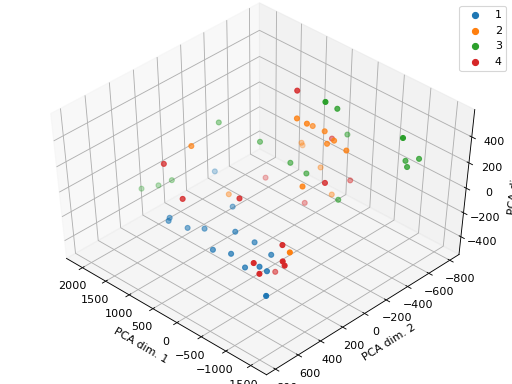

In [136]:
fig = plt.figure()
ax = Axes3D(fig, elev=48, azim=134)

for i in range(1, 5):
    ax.scatter(car_test_features_trans[car_test_target==i, 0], car_test_features_trans[car_test_target==i, 1], \
               car_test_features_trans[car_test_target==i, 2], label=str(i))

lgnd = plt.legend()
ax.set_xlabel('PCA dim. 1')
ax.set_ylabel('PCA dim. 2')
ax.set_zlabel('PCA dim. 3')

for i in range(4):
    lgnd.legendHandles[i]._sizes = [30]

In [137]:
plt.close(fig)

### Accuracy

In [138]:
car_lda = LinearDiscriminantAnalysis()
car_lda.fit(car_train_features_trans, car_train_target)
car_lda_test_predictions = car_lda.predict(car_test_features_trans)
lda_acc =  accuracy_score(car_test_target, car_lda_test_predictions)
print("Accuracy for LDA :", lda_acc)

Accuracy for LDA : 0.5166666666666667


# 9.2. Using LDA

## LDA for the plane data

### Not scaling the data

### Define and Fit

In [139]:
plane_lda = LinearDiscriminantAnalysis(n_components=3)
plane_lda.fit(plane_train_features, plane_train_target)

LinearDiscriminantAnalysis(n_components=3)

### Transform

In [140]:
plane_train_features_trans = plane_lda.transform(plane_train_features)
plane_test_features_trans = plane_lda.transform(plane_test_features)

### Plotting

<IPython.core.display.Javascript object>


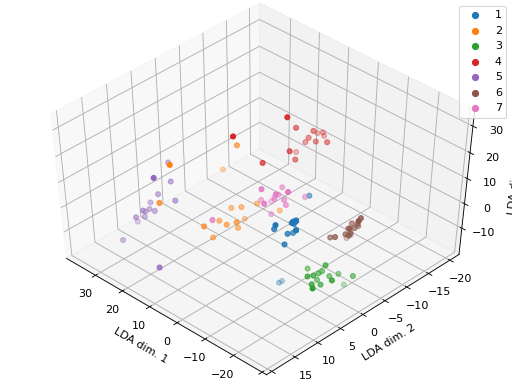

In [141]:
fig = plt.figure()
ax = Axes3D(fig, elev=48, azim=134)

for i in range(1, 8):
    ax.scatter(plane_test_features_trans[plane_test_target==i, 0], plane_test_features_trans[plane_test_target==i, 1], \
               plane_test_features_trans[plane_test_target==i, 2], label=str(i))

ax.set_xlabel('LDA dim. 1')
ax.set_ylabel('LDA dim. 2')
ax.set_zlabel('LDA dim. 3')

lgnd = plt.legend()
for i in range(7):
    lgnd.legendHandles[i]._sizes = [30]

In [142]:
plt.close(fig)

### Accuracy

In [143]:
plane_lda = LinearDiscriminantAnalysis()
plane_lda.fit(plane_train_features_trans, plane_train_target)
plane_lda_test_predictions = plane_lda.predict(plane_test_features_trans)
lda_acc =  accuracy_score(plane_test_target, plane_lda_test_predictions)
print("Accuracy for LDA :", lda_acc)

Accuracy for LDA : 0.9333333333333333


### Scaling the data

In [144]:
plane_lda = LinearDiscriminantAnalysis(n_components=3)
plane_lda.fit(plane_train_features_scaled, plane_train_target)

LinearDiscriminantAnalysis(n_components=3)

### Transform

In [145]:
plane_train_features_trans_scaled = plane_lda.transform(plane_train_features_scaled)
plane_test_features_trans_scaled = plane_lda.transform(plane_test_features_scaled)

### Plotting

<IPython.core.display.Javascript object>


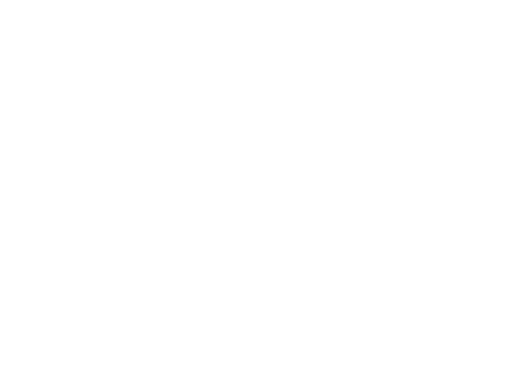

In [146]:
fig = plt.figure()
ax = Axes3D(fig, elev=48, azim=134)

for i in range(1, 8):
    ax.scatter(plane_test_features_trans_scaled[plane_test_target==i, 0], plane_test_features_trans_scaled[plane_test_target==i, 1], \
               plane_test_features_trans_scaled[plane_test_target==i, 2], label=str(i))

ax.set_xlabel('LDA dim. 1')
ax.set_ylabel('LDA dim. 2')
ax.set_zlabel('LDA dim. 3')

lgnd = plt.legend()
for i in range(7):
    lgnd.legendHandles[i]._sizes = [30]

In [147]:
plt.close(fig)

### Accuracy

In [148]:
plane_lda = LinearDiscriminantAnalysis()
plane_lda.fit(plane_train_features_trans_scaled, plane_train_target)
plane_lda_test_predictions = plane_lda.predict(plane_test_features_trans_scaled)
lda_acc =  accuracy_score(plane_test_target, plane_lda_test_predictions_scaled)
print("Accuracy for LDA :", lda_acc)

Accuracy for LDA : 0.9523809523809523


## LDA for the car data

### Not scaling the data

In [149]:
car_lda = LinearDiscriminantAnalysis(n_components=3)
car_lda_trans = car_lda.fit(car_train_features, car_train_target)

### Transform

In [150]:
car_train_features_trans = car_lda.transform(car_train_features)
car_test_features_trans = car_lda.transform(car_test_features)

### Plotting

<IPython.core.display.Javascript object>


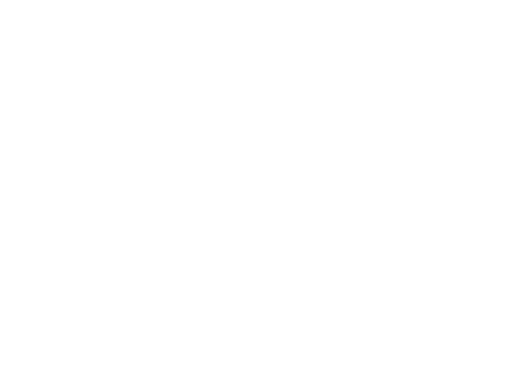

In [151]:
fig = plt.figure()
ax = Axes3D(fig, elev=48, azim=134)

for i in range(1, 5):
    ax.scatter(car_test_features_trans[car_train_target==i, 0], car_test_features_trans[car_train_target==i, 1], \
               car_test_features_trans[car_train_target==i, 2], label=str(i))

ax.set_xlabel('LDA dim. 1')
ax.set_ylabel('LDA dim. 2')
ax.set_zlabel('LDA dim. 3')

lgnd = plt.legend()
for i in range(4):
    lgnd.legendHandles[i]._sizes = [30]

In [152]:
plt.close(fig)

### Accuracy

In [153]:
car_lda = LinearDiscriminantAnalysis()
car_lda.fit(car_train_features_trans, car_train_target)
car_lda_test_predictions = car_lda.predict(car_test_features_trans)
lda_acc =  accuracy_score(car_test_target, car_lda_test_predictions)
print("Accuracy for LDA :", lda_acc)

Accuracy for LDA : 0.9


### Scaling the data

In [154]:
car_lda = LinearDiscriminantAnalysis(n_components=3)
car_lda.fit(car_train_features_scaled, car_train_target)

LinearDiscriminantAnalysis(n_components=3)

### Transform

In [155]:
car_train_features_trans_scaled = car_lda.transform(car_train_features_scaled)
car_test_features_trans_scaled = car_lda.transform(car_test_features_scaled)

### Plotting

<IPython.core.display.Javascript object>


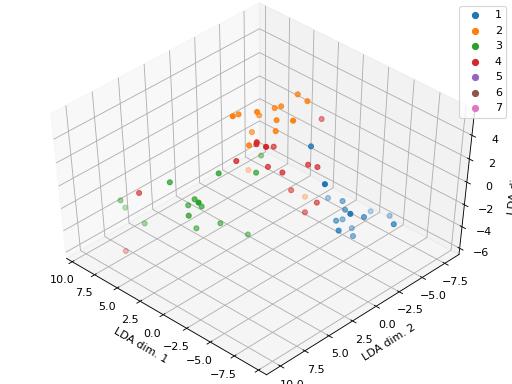

In [156]:
fig = plt.figure()
ax = Axes3D(fig, elev=48, azim=134)

for i in range(1, 8):
    ax.scatter(car_test_features_trans_scaled[car_test_target==i, 0], car_test_features_trans_scaled[car_test_target==i, 1], \
               car_test_features_trans_scaled[car_test_target==i, 2], label=str(i))

ax.set_xlabel('LDA dim. 1')
ax.set_ylabel('LDA dim. 2')
ax.set_zlabel('LDA dim. 3')

lgnd = plt.legend()
for i in range(7):
    lgnd.legendHandles[i]._sizes = [30]

In [157]:
plt.close(fig)

### Accuracy

In [142]:
car_lda = LinearDiscriminantAnalysis()
car_lda.fit(car_train_features_trans_scaled, car_train_target)
car_lda_test_predictions_scaled = car_lda.predict(car_test_features_trans_scaled)
lda_acc =  accuracy_score(car_test_target, car_lda_test_predictions_scaled)
print("Accuracy for LDA :", lda_acc)

Accuracy for LDA : 0.9


# 10. Pipeline Optimization
We use TPOT to generate an optimal pipeline to compare its accuracy with ours. This way we can know how good our classifiers are.

## 10.1. TPOT for the plane data

### Fit

In [143]:
plane_tpot = TPOTClassifier(generations=5, population_size=10, verbosity=2, random_state=16)
plane_tpot.fit(plane_train_features, plane_train_target)
plane_tpot.fitted_pipeline_.steps


Generation 1 - Current best internal CV score: 0.7714285714285715
Generation 2 - Current best internal CV score: 0.9047619047619048
Generation 3 - Current best internal CV score: 0.9047619047619048
Generation 4 - Current best internal CV score: 0.9523809523809523
Generation 5 - Current best internal CV score: 0.9523809523809523
Best pipeline: ExtraTreesClassifier(LinearSVC(input_matrix, C=5.0, dual=True, loss=squared_hinge, penalty=l2, tol=0.001), bootstrap=False, criterion=entropy, max_features=0.8500000000000001, min_samples_leaf=11, min_samples_split=10, n_estimators=100)


[('stackingestimator',
  StackingEstimator(estimator=LinearSVC(C=5.0, random_state=16, tol=0.001))),
 ('extratreesclassifier',
  ExtraTreesClassifier(criterion='entropy', max_features=0.8500000000000001,
                       min_samples_leaf=11, min_samples_split=10,
                       random_state=16))]

### Accuracy

In [144]:
plane_tpot_test_accuracy = plane_tpot.score(plane_test_features, plane_test_target)
print('The test accuracy obtained by tpot classification problem is:', plane_tpot_test_accuracy)

The test accuracy obtained by tpot classification problem is: 0.9238095238095239


## 10.2. TPOT for the car data

### Fit

In [145]:
car_tpot = TPOTClassifier(generations=5, population_size=10, verbosity=2, random_state=16)
car_tpot.fit(car_train_features, car_train_target)
car_tpot.fitted_pipeline_.steps


Generation 1 - Current best internal CV score: 0.8
Generation 2 - Current best internal CV score: 0.8
Generation 3 - Current best internal CV score: 0.8
Generation 4 - Current best internal CV score: 0.8
Generation 5 - Current best internal CV score: 0.8
Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.5, max_depth=4, max_features=0.4, min_samples_leaf=8, min_samples_split=8, n_estimators=100, subsample=0.5)


[('gradientboostingclassifier',
  GradientBoostingClassifier(learning_rate=0.5, max_depth=4, max_features=0.4,
                             min_samples_leaf=8, min_samples_split=8,
                             random_state=16, subsample=0.5))]

### Accuracy

In [146]:
car_tpot_test_accuracy = car_tpot.score(car_test_features, car_test_target)
print('The test accuracy obtained by tpot classification problem is:', car_tpot_test_accuracy)

The test accuracy obtained by tpot classification problem is: 0.8166666666666667
